In [6]:
import os
import io
import sys
import shutil
import pandas as pd
from megadetector.detection.run_detector_batch import load_and_run_detector_batch, write_results_to_file
from megadetector.utils import path_utils
from PIL import Image
import re
import json
from tqdm import tqdm

# Define paths
input_excel = '../data/detector_tests/labelled_photos_file_paths.xlsx'
processed_folder = '/media/tom-ratsakatika/CRUCIAL 4TB/FCC Camera Trap Data/processed/'
cropped_folder = '/media/tom-ratsakatika/CRUCIAL 4TB/FCC Camera Trap Data/cropped/'
empty_folder = os.path.join(processed_folder, 'Empty')
output_file = os.path.join(processed_folder, 'results.json')

os.makedirs(processed_folder, exist_ok=True)
os.makedirs(empty_folder, exist_ok=True)

data = pd.read_excel(input_excel)

data['New File Name'] = ''

def sanitize_label(label):
    return re.sub(r'[\\/*?:"<>|]', "", label)

file_counter = 1


### Copy files from file path in excel file to processed folder, organised into directories = ground truth species

In [7]:
output_buffer = sys.stdout

sys.stdout = io.StringIO()

# Copy images to corresponding label folders with new names
for index, row in tqdm(data.iterrows(), total=data.shape[0], desc="Copying images"):
    original_path = row['Full File Name']
    label = sanitize_label(row['Ground_Truth'])
    new_name = f"{file_counter:06d}" + os.path.splitext(original_path)[1]  # Generate an incremental unique name
    new_folder = os.path.join(processed_folder, label)
    os.makedirs(new_folder, exist_ok=True)
    new_path = os.path.join(new_folder, new_name)
    
    try:
        shutil.copy2(original_path, new_path)
        data.at[index, 'New File Name'] = new_path
        file_counter += 1
    except FileNotFoundError:
        print(f"Error: {original_path} not found. Skipping.")

updated_excel = input_excel.replace('.xlsx', '_file_paths.xlsx')
data.to_excel(updated_excel, index=False)
print("Copying complete. Updated Excel saved at:", updated_excel)

Copying images: 100%|██████████| 19597/19597 [01:01<00:00, 320.26it/s]


### Run through all the files in the processed folder with MegaDetector

In [8]:
# Recursively find images in the processed folder

image_file_names = path_utils.find_images(processed_folder, recursive=True)

sys.stdout = io.StringIO()

confidence_threshold = 0.005

# Run MegaDetector, default confidence threshold 0.005
results = load_and_run_detector_batch('MDV5A', image_file_names, confidence_threshold)

# Write results to output file
write_results_to_file(results, output_file, relative_path_base=processed_folder, detector_file='MDV5A')

Fusing layers... 
Fusing layers... 
Model summary: 733 layers, 140054656 parameters, 0 gradients, 208.8 GFLOPs
Model summary: 733 layers, 140054656 parameters, 0 gradients, 208.8 GFLOPs
 12%|█▏        | 2303/19597 [12:08<1:43:00,  2.80it/s]/home/tom-ratsakatika/VSCode/camera-traps/.venv/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 19597/19597 [1:37:25<00:00,  3.35it/s]


{'images': [{'file': 'Badger/000006.JPG',
   'detections': [{'category': '1',
     'conf': 0.932,
     'bbox': [0.1203, 0.6805, 0.288, 0.1986]}]},
  {'file': 'Badger/000007.JPG',
   'detections': [{'category': '1',
     'conf': 0.886,
     'bbox': [0.539, 0.6465, 0.2234, 0.1006]}]},
  {'file': 'Badger/000008.JPG',
   'detections': [{'category': '1',
     'conf': 0.929,
     'bbox': [0.6239, 0.6243, 0.1864, 0.1152]}]},
  {'file': 'Badger/000026.JPG',
   'detections': [{'category': '1',
     'conf': 0.931,
     'bbox': [0.5205, 0.4324, 0.137, 0.09022]}]},
  {'file': 'Badger/000091.JPG',
   'detections': [{'category': '1',
     'conf': 0.925,
     'bbox': [0.3843, 0.6437, 0.3145, 0.1812]}]},
  {'file': 'Badger/000225.JPG',
   'detections': [{'category': '1',
     'conf': 0.883,
     'bbox': [0.3929, 0.6002, 0.1543, 0.09696]}]},
  {'file': 'Badger/000228.JPG',
   'detections': [{'category': '1',
     'conf': 0.804,
     'bbox': [0.463, 0.6062, 0.4166, 0.1486]}]},
  {'file': 'Badger/000268.

### Add Megadetector Results to the Excel File

In [10]:
import pandas as pd
import json

# Define paths
excel_path = "../data/detector_tests/labelled_photos_file_paths.xlsx"
json_path = "../data/detector_tests/results.json"

# Load the Excel file
df = pd.read_excel(excel_path)

# Load the JSON file
with open(json_path, 'r') as f:
    results = json.load(f)

# Create dictionaries to store the highest confidence category and its confidence for each file
file_category_mapping = {}
file_confidence_mapping = {}

# Populate the dictionaries with the highest confidence category and its confidence for each file
for entry in results['images']:
    file_name = entry['file']
    detections = entry['detections']
    if detections:
        highest_conf_detection = max(detections, key=lambda x: x['conf'])
        category = highest_conf_detection['category']
        confidence = highest_conf_detection['conf']
        if category == "1":
            file_category_mapping[file_name] = "Animal"
        elif category == "2":
            file_category_mapping[file_name] = "Human"
        elif category == "3":
            file_category_mapping[file_name] = "Vehicle"
        file_confidence_mapping[file_name] = confidence
    else:
        file_category_mapping[file_name] = "Empty"
        file_confidence_mapping[file_name] = 0.0

# Function to find the highest confidence category for each row
def get_highest_conf_category(file_path):
    for key in file_category_mapping:
        if key in file_path:
            return file_category_mapping[key]
    return "Error"

# Function to find the highest confidence value for each row
def get_highest_conf_value(file_path):
    for key in file_confidence_mapping:
        if key in file_path:
            return file_confidence_mapping[key]
    return 0.0

# Add or update the 'MegaDetector' and 'MegaDetector_Conf' columns in the DataFrame
df['MegaDetector'] = df['New File Name'].apply(get_highest_conf_category)
df['MegaDetector_Conf'] = df['New File Name'].apply(get_highest_conf_value)

# Save the updated DataFrame back to Excel
df.to_excel(f"{excel_path.rstrip('.xlsx')}_detections.xlsx", index=False)

### Crop images and save - higher confidence threshold used

In [ ]:
import json
import shutil
import os
from tqdm import tqdm
from PIL import Image
import sys

confidence_threshold = 0.2

with open(output_file) as f:
    detection_results = json.load(f)

for image_data in tqdm(detection_results['images'], desc="Cropping images"):
    image_path = processed_folder + image_data['file']
    detections = image_data['detections']
    
    if not detections:
        # Ensure source and destination are not the same
        dest_path = os.path.join(empty_folder, os.path.basename(image_path))
        if image_path != dest_path:
            shutil.copy2(image_path, empty_folder)
        # os.remove(image_path)
        continue
    
    cropped_counter = 1

    for i, detection in enumerate(detections):
        if detection['conf'] < confidence_threshold:
            continue
        bbox = detection['bbox']
        img = Image.open(image_path)
        width, height = img.size
        left = bbox[0] * width
        top = bbox[1] * height
        right = left + bbox[2] * width
        bottom = top + bbox[3] * height
        cropped_img = img.crop((left, top, right, bottom))

        # Create new file path lower extension and _# for number of detections
        dir_name, base_name = os.path.split(image_path)
        base, ext = os.path.splitext(base_name)
        new_file_name = f"{base}_{cropped_counter}{ext.lower()}"
        new_image_path = os.path.join(dir_name, new_file_name)
        
        cropped_img.save(new_image_path)

        cropped_counter += 1

sys.stdout = output_buffer


### Move cropped files into own folder

In [ ]:
def move_files_with_underscore(processed_folder, cropped_folder):
    # First, count the total number of files to be moved
    total_files = sum(len(files) for _, _, files in os.walk(processed_folder) if any("_" in file for file in files))
    
    with tqdm(total=total_files, desc="Moving files", unit="file") as pbar:
        for root, dirs, files in os.walk(processed_folder):
            for file in files:
                if "_" in file:
                    source_path = os.path.join(root, file)
                    relative_path = os.path.relpath(root, processed_folder)
                    dest_dir = os.path.join(cropped_folder, relative_path)
                    os.makedirs(dest_dir, exist_ok=True)
                    
                    dest_path = os.path.join(dest_dir, file)
                    
                    shutil.move(source_path, dest_path)
                    pbar.update(1)
                    print(f"Moved {source_path} to {dest_path}")


move_files_with_underscore(processed_folder, cropped_folder)


#### Function to count files

In [ ]:
def count_files_in_subfolders(folder):
    file_count = {}
    for root, dirs, files in os.walk(folder):
        num_files = len(files)
        file_count[root] = num_files
    return file_count

file_counts = count_files_in_subfolders(cropped_folder)

for folder, count in file_counts.items():
    print(f"{folder}: {count} files")

### Split files into train/validation/test sets grouped by sequence ID

In [ ]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import defaultdict

# Define paths
input_excel_updated = '/home/tom-ratsakatika/VSCode/camera-traps/data/structured_data_with_deepfaune_updated.xlsx'
output_base_folder = '/media/tom-ratsakatika/CRUCIAL 4TB/FCC Camera Trap Data/split_data'

train_folder = os.path.join(output_base_folder, 'train')
val_folder = os.path.join(output_base_folder, 'val')
test_folder = os.path.join(output_base_folder, 'test')

for folder in [train_folder, val_folder, test_folder]:
    os.makedirs(folder, exist_ok=True)

df = pd.read_excel(input_excel_updated)

classes_of_interest = {
    'badger', 'ibex', 'red deer', 'chamois', 'cat', 'goat', 'roe deer', 'dog', 'squirrel', 'equid', 'genet',
    'hedgehog', 'lagomorph', 'wolf', 'lynx', 'marmot', 'micromammal', 'mouflon', 'sheep', 'mustelid', 'bird', 
    'bear', 'nutria', 'fox', 'wild boar', 'cow'
}

df['class'] = df['New File Name'].apply(lambda x: os.path.basename(os.path.dirname(x)).lower())
df = df[df['class'].isin(classes_of_interest)]

sequence_dict = defaultdict(list)
for _, row in df.iterrows():
    original_file_name = os.path.basename(row['New File Name'])
    sequence_dict[row['seqnum']].append((row['class'], original_file_name))

sequence_ids = list(sequence_dict.keys())
train_ids, temp_ids = train_test_split(sequence_ids, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

def move_files(sequence_ids, target_folder):
    for seq_id in sequence_ids:
        for class_label, original_file_name in sequence_dict[seq_id]:
            cropped_files = [f for f in os.listdir(os.path.join(cropped_folder, class_label)) if f.startswith(original_file_name.split('.')[0])]
            for cropped_file in cropped_files:
                source_path = os.path.join(cropped_folder, class_label, cropped_file)
                target_dir = os.path.join(target_folder, class_label)
                os.makedirs(target_dir, exist_ok=True)
                shutil.move(source_path, target_dir)

move_files(train_ids, train_folder)
move_files(val_ids, val_folder)
move_files(test_ids, test_folder)

### Calculate descriptive statistics of train/val/test sets

In [20]:
import os
import pandas as pd
from collections import defaultdict

def count_files_in_directory(directory):
    class_counts = defaultdict(int)
    for root, _, files in os.walk(directory):
        for file in files:
            class_label = os.path.basename(root)
            class_counts[class_label] += 1
    return class_counts


train_counts = count_files_in_directory(train_folder)
val_counts = count_files_in_directory(val_folder)
test_counts = count_files_in_directory(test_folder)

counts_df = pd.DataFrame({
    'Train': train_counts,
    'Validation': val_counts,
    'Test': test_counts
}).fillna(0).astype(int)

counts_df['Total'] = counts_df.sum(axis=1)

counts_df.loc['Total'] = counts_df.sum(axis=0)

counts_df['Train %'] = (counts_df['Train'] / counts_df['Total']) * 100
counts_df['Validation %'] = (counts_df['Validation'] / counts_df['Total']) * 100
counts_df['Test %'] = (counts_df['Test'] / counts_df['Total']) * 100

counts_df['Train %'] = counts_df['Train %'].round(0).astype(int)
counts_df['Validation %'] = counts_df['Validation %'].round(0).astype(int)
counts_df['Test %'] = counts_df['Test %'].round(0).astype(int)

counts_df = counts_df.sort_index()

cols = ['Total', 'Train', 'Validation', 'Test', 'Train %', 'Validation %', 'Test %']
counts_df = counts_df[cols]

print(counts_df)


           Total  Train  Validation  Test  Train %  Validation %  Test %
Total      24562  17336        3669  3557       71            15      14
badger       417    305          59    53       73            14      13
bear        3207   2329         352   526       73            11      16
bird         939    695         123   121       74            13      13
cat          356    276          25    55       78             7      15
chamois       41     34           4     3       83            10       7
cow          348    253          65    30       73            19       9
dog         1110    894         115   101       81            10       9
equid        446    214          50   182       48            11      41
fox         2286   1608         328   350       70            14      15
goat        1593   1350         165    78       85            10       5
lagomorph    107     81          15    11       76            14      10
lynx        1172    764         224   184       65 

### Display random sample of cropped images

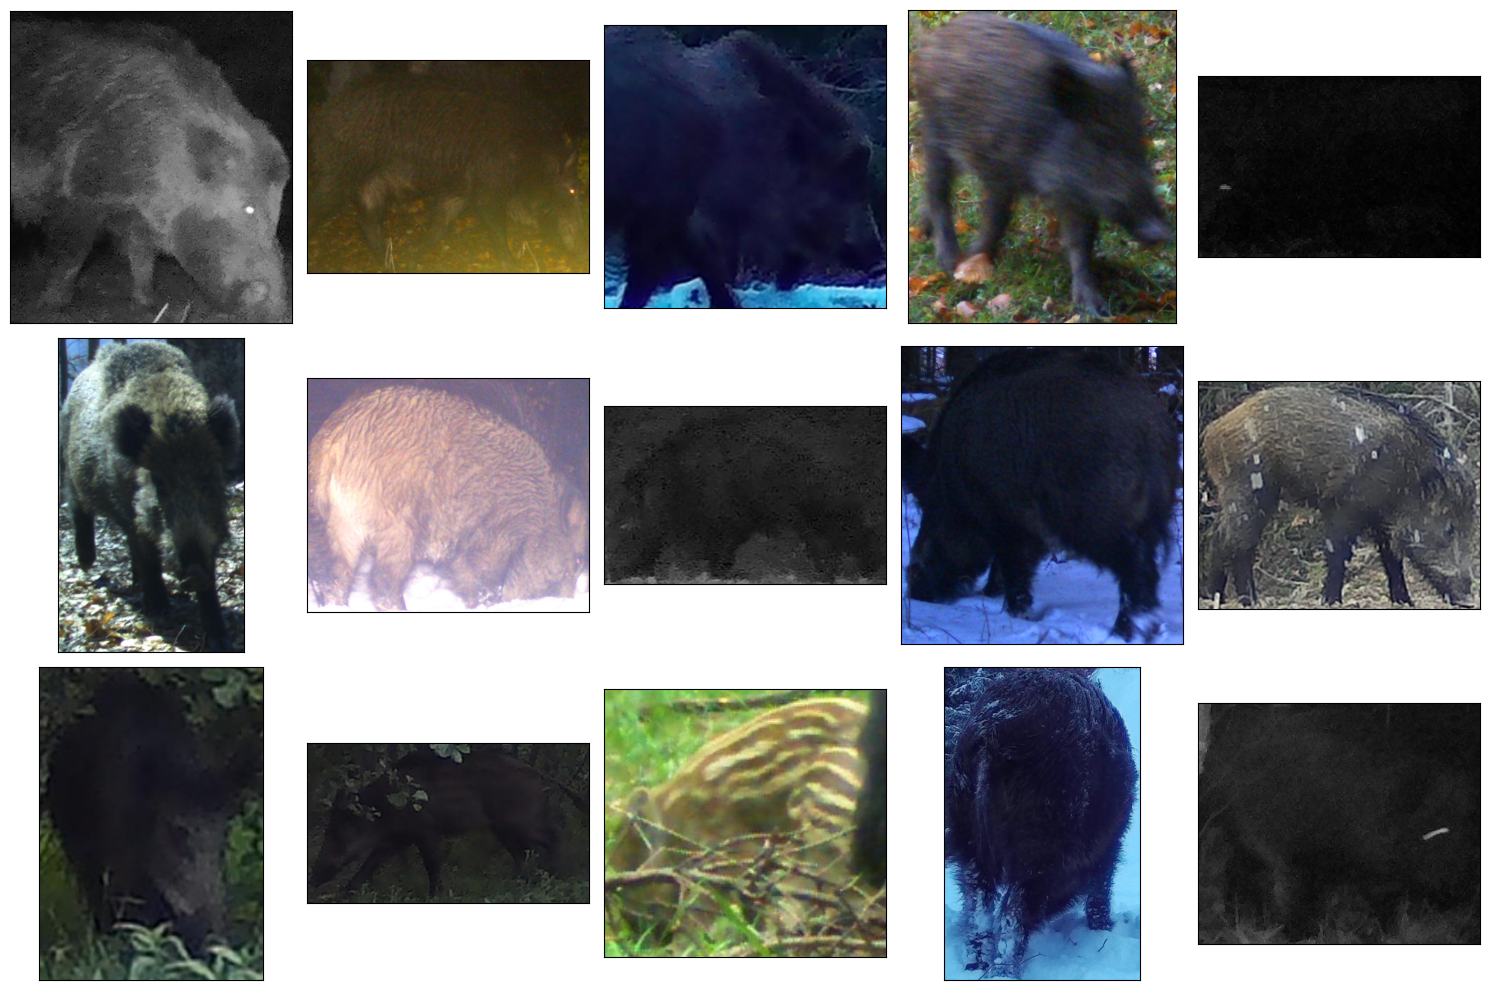

In [55]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

image_dir = "/media/tom-ratsakatika/CRUCIAL 4TB/Processed/split_data/test/wild boar"

all_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

sample_files = random.sample(all_files, 50)


fig, axes = plt.subplots(3, 5, figsize=(15, 10))


for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

for ax, img_path in zip(axes.flatten(), sample_files):
    img = Image.open(img_path)
    ax.imshow(img)


plt.tight_layout()
plt.show()


### Add train/val/test information to Excel File

In [3]:
import os
import pandas as pd
from tqdm import tqdm

# Define paths
excel_path = "/home/tom-ratsakatika/VSCode/camera-traps/data/structured_data_with_deepfaune_updated.xlsx"
data_dir = "/media/tom-ratsakatika/CRUCIAL 4TB/FCC Camera Trap Data/split_data"

# Load Excel file
df = pd.read_excel(excel_path)

# Add a new column 'Set' to the DataFrame
df['Set'] = None

# Count the total number of files for the progress bar
total_files = sum([len(files) for r, d, files in os.walk(data_dir) if files])

# Walk through each file in the directory and subdirectories with a progress bar
with tqdm(total=total_files, desc="Processing files") as pbar:
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.jpg'):
                # Extract the part of the file name before '_'
                file_id = file.split('_')[0]

                # Determine the set name based on the directory structure
                set_name = root.split(os.sep)[-2]  # 'train', 'val', or 'test'

                # Find the row in the DataFrame where 'New File Name' contains file_id
                df.loc[df['New File Name'].str.contains(file_id, na=False), 'Set'] = set_name.capitalize()
                
                # Update the progress bar
                pbar.update(1)

# Save the updated DataFrame back to Excel
df.to_excel(excel_path, index=False)


Processing files: 100%|██████████| 24562/24562 [01:34<00:00, 259.97it/s]
